This notebook aims to implement the optimal reaction coordinate framework to predict time to death from the top 50 CpG sites I identified as most significantly associated with age. However, unlike in the previous notebook, where I set a surrogate endpoint for all individuals, here I will only set a surrogate endpoint for individuals who have lived a long time already and therefore are potentially closer to death. Again, this requires using forward dynamics

First, I will read significant_betas.csv, which contains the IDs, chronological ages and beta values at the top 50 CpG sites most significantly associated with age for all 1070 samples. 

In [1]:
#import packages
from pathlib import Path
from mepylome import MethylData
import pandas as pd
import csv
import numpy as np

In [2]:
significant = pd.read_csv("significant_betas.csv")
significant.head(10)

,ID,Age,cg16867657,cg22454769,cg07082267,cg10917602,cg23744638,cg26153045,cg02085953,cg07927379,...,cg00292135,cg11693709,cg23737927,cg16624521,cg25994988,cg06761850,cg02315732,cg20732076,cg04608933,cg11436767
0,1,89.901370,0.702134,0.617247,0.309282,0.480625,0.556098,0.321821,0.314697,0.073288,...,0.114535,0.256534,0.586134,0.656403,0.411849,0.292660,0.398222,0.105039,0.653653,0.373123
1,2,94.000000,0.729290,0.731379,0.213783,0.449248,0.494431,0.324626,0.296414,0.018520,...,0.174267,0.231969,0.604058,0.568733,0.336492,0.339834,0.321057,0.041996,0.619470,0.282783
2,3,97.879450,0.688162,0.681539,0.342350,0.498799,0.566515,0.213102,0.275044,0.040328,...,0.134725,0.198174,0.612303,0.565486,0.348359,0.183476,0.414816,0.065445,0.648604,0.316858
3,4,66.530134,0.646309,0.486484,0.380866,0.583188,0.569642,0.375602,0.354024,0.042392,...,0.114310,0.417675,0.759947,0.681296,0.474299,0.296988,0.560873,0.190937,0.675305,0.406668
4,4,73.568486,0.799299,0.495504,0.357534,0.543829,0.527590,0.311308,0.308736,0.043762,...,0.107074,0.411936,0.833769,0.659152,0.384782,0.281054,0.561824,0.155627,0.655442,0.400266
5,4,82.403833,0.737156,0.547054,0.414491,0.577654,0.553128,0.342647,0.267324,0.160710,...,0.150684,0.392358,0.639692,0.683428,0.451075,0.311980,0.428577,0.153598,0.706284,0.374923
6,4,84.528405,0.837627,0.559392,0.355323,0.525814,0.521606,0.253690,0.271183,0.079572,...,0.089873,0.393527,0.699139,0.644453,0.331450,0.325187,0.373445,0.112596,0.678522,0.353805
7,5,66.530134,0.702288,0.526904,0.361381,0.543922,0.672069,0.348870,0.322995,0.105713,...,0.141782,0.382297,0.741858,0.559220,0.405146,0.290188,0.452989,0.120012,0.625062,0.417433
8,5,73.852509,0.820860,0.577691,0.373576,0.498148,0.614670,0.316506,0.343476,0.077343,...,0.178324,0.347342,0.727501,0.505839,0.344634,0.308590,0.524471,0.104955,0.599907,0.342823
9,5,82.403833,0.838836,0.572076,0.304438,0.486565,0.655282,0.244592,0.348290,0.133586,...,0.159521,0.314774,0.627057,0.513647,0.366603,0.238929,0.452037,0.105946,0.573729,0.392948


To implement the optimal RC framework, I need to use the OptimalRCs Python library. This library is for computing optimal RCs from trajectory data using a nonparametric framework. 

In [3]:
import math
import numpy as np
import matplotlib.pyplot as plt

import os
import tensorflow as tf
os.environ['TF_FORCE_GPU_ALLOW_GROWTH']='true'
import OptimalRCs

2025-08-19 12:34:43.729081: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1755603283.740541 1125893 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1755603283.744074 1125893 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1755603283.752657 1125893 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1755603283.752667 1125893 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1755603283.752668 1125893 computation_placer.cc:177] computation placer alr

I will remove all the individuals who only have one sample. 

In [4]:
# remove samples where there is only one sample per patient 
filtered = significant[significant['ID'].map(significant['ID'].value_counts()) > 1]

filtered.head(10)

,ID,Age,cg16867657,cg22454769,cg07082267,cg10917602,cg23744638,cg26153045,cg02085953,cg07927379,...,cg00292135,cg11693709,cg23737927,cg16624521,cg25994988,cg06761850,cg02315732,cg20732076,cg04608933,cg11436767
3,4,66.530134,0.646309,0.486484,0.380866,0.583188,0.569642,0.375602,0.354024,0.042392,...,0.114310,0.417675,0.759947,0.681296,0.474299,0.296988,0.560873,0.190937,0.675305,0.406668
4,4,73.568486,0.799299,0.495504,0.357534,0.543829,0.527590,0.311308,0.308736,0.043762,...,0.107074,0.411936,0.833769,0.659152,0.384782,0.281054,0.561824,0.155627,0.655442,0.400266
5,4,82.403833,0.737156,0.547054,0.414491,0.577654,0.553128,0.342647,0.267324,0.160710,...,0.150684,0.392358,0.639692,0.683428,0.451075,0.311980,0.428577,0.153598,0.706284,0.374923
6,4,84.528405,0.837627,0.559392,0.355323,0.525814,0.521606,0.253690,0.271183,0.079572,...,0.089873,0.393527,0.699139,0.644453,0.331450,0.325187,0.373445,0.112596,0.678522,0.353805
7,5,66.530134,0.702288,0.526904,0.361381,0.543922,0.672069,0.348870,0.322995,0.105713,...,0.141782,0.382297,0.741858,0.559220,0.405146,0.290188,0.452989,0.120012,0.625062,0.417433
8,5,73.852509,0.820860,0.577691,0.373576,0.498148,0.614670,0.316506,0.343476,0.077343,...,0.178324,0.347342,0.727501,0.505839,0.344634,0.308590,0.524471,0.104955,0.599907,0.342823
9,5,82.403833,0.838836,0.572076,0.304438,0.486565,0.655282,0.244592,0.348290,0.133586,...,0.159521,0.314774,0.627057,0.513647,0.366603,0.238929,0.452037,0.105946,0.573729,0.392948
10,5,84.531143,0.840359,0.596924,0.263943,0.493135,0.623089,0.301661,0.289652,0.175717,...,0.189232,0.281201,0.625621,0.495396,0.306589,0.238906,0.361037,0.113026,0.575963,0.334129
13,8,66.086073,0.627704,0.647375,0.340258,0.562467,0.671710,0.422431,0.350998,0.021660,...,0.103973,0.384872,0.736366,0.791442,0.449353,0.404055,0.464297,0.132798,0.724789,0.339484
14,8,73.086073,0.632956,0.559031,0.360567,0.523835,0.644331,0.354333,0.358797,0.066688,...,0.127887,0.416096,0.771702,0.760272,0.487935,0.364762,0.399825,0.136559,0.702881,0.371609


In [5]:
filtered.shape

(914, 52)

There are 914 samples where there are 2 or more samples per patient. 

In [23]:
(filtered['Age'] > 92).sum()

np.int64(13)

There are 13 samples where the individual older than 92. I want to try time to death for only these individuals. To do this I will set an approximate death of age 100 for only these individuals. 

In [24]:
# Create a new DataFrame to store the result
close_to_death = pd.DataFrame(columns=filtered.columns)

for uid in unique_ids:
    # Get all rows for this individual
    individual_rows = filtered[filtered['ID'] == uid]
    
    # Only proceed if the sample has an age > 92
    if (individual_rows['Age'] > 92).any():
        # Create a zero-filled row
        zero_row = pd.DataFrame([[0]*len(filtered.columns)], columns=filtered.columns)
        zero_row.at[0, 'ID'] = uid
        zero_row.at[0, 'Age'] = 100 

        # Concatenate individual's data followed by the zero_row
        combined = pd.concat([individual_rows, zero_row], ignore_index=True)

        # Append to result DataFrame
        close_to_death = pd.concat([close_to_death, combined], ignore_index=True)
    else:
        # If not > 92, just keep the individual's rows as-is
        close_to_death = pd.concat([close_to_death, individual_rows], ignore_index=True)

close_to_death.iloc[100:150,:]

,ID,Age,cg16867657,cg22454769,cg07082267,cg10917602,cg23744638,cg26153045,cg02085953,cg07927379,...,cg00292135,cg11693709,cg23737927,cg16624521,cg25994988,cg06761850,cg02315732,cg20732076,cg04608933,cg11436767
100,97,86.669405,0.873695,0.579487,0.316486,0.521077,0.475221,0.392819,0.271930,0.031847,...,0.293656,0.363223,0.743738,0.412932,0.422526,0.223253,0.356834,0.140617,0.620256,0.421081
101,101,77.478085,0.788059,0.564477,0.316317,0.597027,0.670824,0.395215,0.344139,0.156643,...,0.099005,0.313188,0.711335,0.613052,0.416901,0.236395,0.445609,0.132616,0.678775,0.361920
102,101,84.439733,0.862520,0.667797,0.361490,0.551271,0.643163,0.358984,0.310902,0.043774,...,0.105122,0.210769,0.591038,0.538805,0.378481,0.190068,0.399159,0.061064,0.637517,0.375764
103,102,91.822040,0.777825,0.726893,0.385588,0.720573,0.526929,0.431089,0.329972,0.105437,...,0.186324,0.421215,0.661982,0.593902,0.473967,0.345399,0.368279,0.103919,0.728397,0.420360
104,102,94.091718,0.778600,0.735257,0.360285,0.621855,0.478873,0.333067,0.305160,0.103380,...,0.117023,0.352697,0.610794,0.586030,0.379641,0.331947,0.398379,0.104964,0.613347,0.381099
105,102,100.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
106,103,77.535613,0.641722,0.607560,0.383253,0.684761,0.626366,0.292872,0.341207,0.061918,...,0.039319,0.492397,0.709402,0.635662,0.449692,0.338582,0.380286,0.067238,0.687018,0.427749
107,103,84.379904,0.627125,0.602568,0.311349,0.657766,0.635780,0.377383,0.337566,0.032339,...,0.191092,0.402576,0.576689,0.596621,0.367314,0.351128,0.532523,0.139239,0.604174,0.359905
108,103,87.378508,0.691384,0.712361,0.335130,0.660356,0.649663,0.378216,0.344976,0.052598,...,0.104703,0.361092,0.605263,0.650096,0.486395,0.296346,0.637094,0.176150,0.654264,0.444419
109,104,82.460497,0.689664,0.735978,0.338990,0.542825,0.566773,0.416030,0.355921,0.069872,...,0.153934,0.300251,0.628186,0.611781,0.430929,0.247873,0.466108,0.091538,0.621853,0.389234


In [25]:
xtraj = close_to_death.iloc[:, 2:].to_numpy()
xtraj = xtraj.astype(np.float32)
xtraj

array([[0.6463094 , 0.48648372, 0.38086602, ..., 0.19093734, 0.6753051 ,
        0.40666825],
       [0.7992989 , 0.49550393, 0.3575344 , ..., 0.15562695, 0.65544224,
        0.4002661 ],
       [0.7371562 , 0.54705423, 0.41449058, ..., 0.15359783, 0.7062843 ,
        0.37492344],
       ...,
       [0.6106838 , 0.50496006, 0.34109205, ..., 0.07251415, 0.66999286,
        0.38615233],
       [0.6564735 , 0.53342724, 0.32542562, ..., 0.10561421, 0.6592708 ,
        0.43372092],
       [0.73187643, 0.5062885 , 0.35437346, ..., 0.10092261, 0.70163155,
        0.40843266]], shape=(925, 50), dtype=float32)

In [26]:
ptrajne = close_to_death.iloc[:, 0].to_numpy()
ptrajne = ptrajne.astype(np.float32)
ptrajne

array([  4.,   4.,   4.,   4.,   5.,   5.,   5.,   5.,   8.,   8.,   8.,
         8.,   8.,   9.,   9.,   9.,   9.,  10.,  10.,  11.,  11.,  12.,
        12.,  12.,  12.,  12.,  13.,  13.,  13.,  25.,  25.,  25.,  34.,
        34.,  39.,  39.,  39.,  42.,  42.,  45.,  45.,  50.,  50.,  51.,
        51.,  54.,  54.,  54.,  54.,  55.,  55.,  55.,  55.,  55.,  67.,
        67.,  68.,  68.,  72.,  72.,  73.,  73.,  75.,  75.,  75.,  76.,
        76.,  77.,  77.,  79.,  79.,  79.,  79.,  80.,  80.,  85.,  85.,
        86.,  86.,  86.,  89.,  89.,  90.,  90.,  90.,  90.,  91.,  91.,
        92.,  92.,  92.,  92.,  95.,  95.,  95.,  95.,  95.,  95.,  97.,
        97.,  97., 101., 101., 102., 102., 102., 103., 103., 103., 104.,
       104., 104., 105., 105., 107., 107., 107., 107., 108., 108., 110.,
       110., 116., 116., 116., 119., 119., 119., 119., 119., 119., 121.,
       121., 125., 125., 126., 126., 128., 128., 131., 131., 132., 132.,
       133., 133., 134., 134., 134., 135., 135., 13

In [27]:
ttrajne = close_to_death.iloc[:, 1].to_numpy()
ttrajne = ttrajne.astype(np.float32)
ttrajne

array([ 66.530136,  73.56849 ,  82.40383 ,  84.528404,  66.530136,
        73.85251 ,  82.40383 ,  84.53114 ,  66.086075,  73.086075,
        76.04655 ,  82.06434 ,  84.16427 ,  66.086075,  73.136536,
        76.134155,  82.28337 ,  67.4726  ,  74.34703 ,  67.78128 ,
        74.84977 ,  65.80205 ,  72.84429 ,  75.83025 ,  81.806984,
        83.87953 ,  72.7774  ,  81.765915,  83.86037 ,  85.35799 ,
        92.25274 , 100.      ,  88.11462 ,  91.123886,  80.92763 ,
        87.870094,  90.850105,  82.49178 ,  89.03403 ,  87.9468  ,
        91.23614 ,  80.0532  ,  88.25479 ,  85.80868 ,  88.73374 ,
        86.292244,  89.36893 ,  97.264885, 100.      ,  78.7758  ,
        88.90075 ,  94.74606 ,  96.90623 , 100.      ,  80.02466 ,
        86.73357 ,  80.02466 ,  87.06142 ,  79.280136,  86.236305,
        78.32511 ,  85.263695,  77.2774  ,  84.30046 ,  87.21971 ,
        84.29498 ,  87.34018 ,  77.707756,  84.79383 ,  78.31142 ,
        85.22809 ,  95.77824 , 100.      ,  76.967125,  86.965

In [28]:
age = close_to_death.iloc[:, 1].to_numpy()
age = age.astype(np.float32)
age

array([ 66.530136,  73.56849 ,  82.40383 ,  84.528404,  66.530136,
        73.85251 ,  82.40383 ,  84.53114 ,  66.086075,  73.086075,
        76.04655 ,  82.06434 ,  84.16427 ,  66.086075,  73.136536,
        76.134155,  82.28337 ,  67.4726  ,  74.34703 ,  67.78128 ,
        74.84977 ,  65.80205 ,  72.84429 ,  75.83025 ,  81.806984,
        83.87953 ,  72.7774  ,  81.765915,  83.86037 ,  85.35799 ,
        92.25274 , 100.      ,  88.11462 ,  91.123886,  80.92763 ,
        87.870094,  90.850105,  82.49178 ,  89.03403 ,  87.9468  ,
        91.23614 ,  80.0532  ,  88.25479 ,  85.80868 ,  88.73374 ,
        86.292244,  89.36893 ,  97.264885, 100.      ,  78.7758  ,
        88.90075 ,  94.74606 ,  96.90623 , 100.      ,  80.02466 ,
        86.73357 ,  80.02466 ,  87.06142 ,  79.280136,  86.236305,
        78.32511 ,  85.263695,  77.2774  ,  84.30046 ,  87.21971 ,
        84.29498 ,  87.34018 ,  77.707756,  84.79383 ,  78.31142 ,
        85.22809 ,  95.77824 , 100.      ,  76.967125,  86.965

In [29]:
IndA = age>99
IndA

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False,  True, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False,  True, False, False, False, False,  True,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
        True, False, False, False, False, False, False, False, False,
       False, False, False, False,  True, False, False, False, False,
       False,  True, False, False, False, False, False,  True, False,
       False, False, False, False, False, False,  True, False, False,
       False, False, False,  True, False, False, False, False, False,
        True, False, False, False, False, False, False, False, False,
       False, False,

iteration 0, loss=-981.964, delta_r=98.2883, |dx|=0.747949, time=0.104563
iteration 1000, loss=-573.692, delta_r=75.4191, |dx|=0.434243, time=1.47932
iteration 2000, loss=-530.037, delta_r=64.2496, |dx|=0.089754, time=2.83695
iteration 3000, loss=-519.15, delta_r=74.321, |dx|=0.0594941, time=4.18652
iteration 4000, loss=-535.745, delta_r=78.0645, |dx|=0.023614, time=5.54721
iteration 5000, loss=-545.666, delta_r=88.6607, |dx|=0.0196732, time=6.90317
iteration 6000, loss=-579.592, delta_r=140.149, |dx|=0.0310392, time=8.26017
iteration 7000, loss=-560.856, delta_r=71.8251, |dx|=0.103829, time=9.60783
iteration 8000, loss=-638.725, delta_r=80.1584, |dx|=0.0794779, time=10.9652
iteration 9000, loss=-679.181, delta_r=86.2577, |dx|=0.046801, time=12.3123
iteration 10000, loss=-716.451, delta_r=85.4101, |dx|=0.038559, time=13.6847
iteration 11000, loss=-712.687, delta_r=87.077, |dx|=0.0201171, time=15.0637
iteration 12000, loss=-760.685, delta_r=94.9811, |dx|=0.0456668, time=16.4388
iteratio

/localhome/home/fbsskr/Notebooks/Students/Ella/Methylation/OptimalRCs.py:2080: RuntimeWarning: divide by zero encountered in log
  if lnzmfpt: ly = -np.log(ly)
/localhome/home/fbsskr/Notebooks/Students/Ella/Methylation/OptimalRCs.py:2080: RuntimeWarning: invalid value encountered in log
  if lnzmfpt: ly = -np.log(ly)


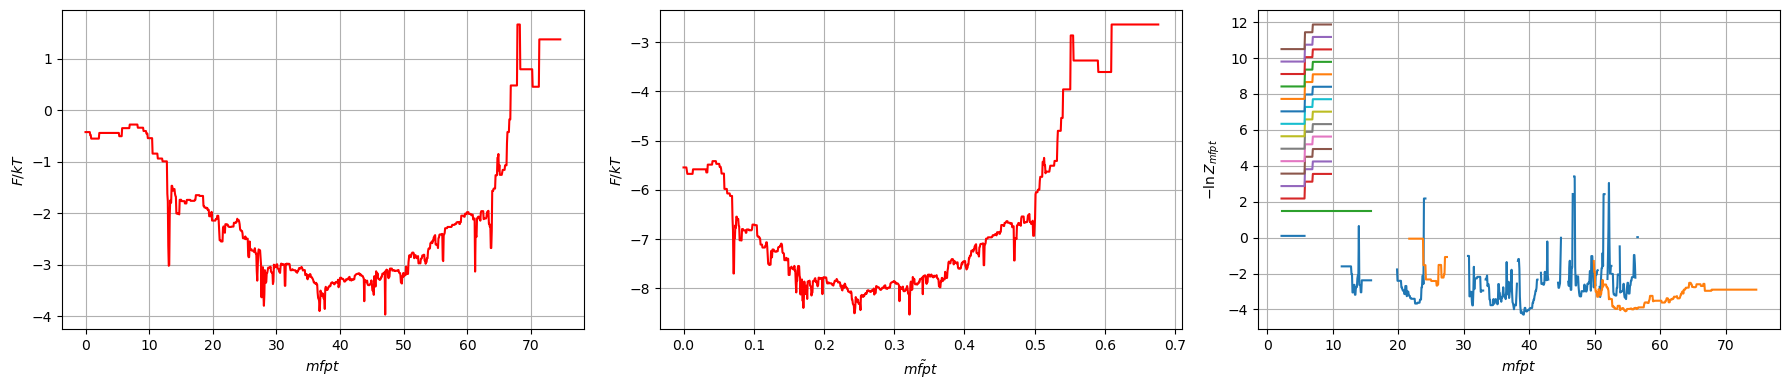

In [30]:
OptimalRCs.envelope_scale=0.01

def comp_y():
    return xtraj[:,np.random.randint(xtraj.shape[1])]

q=OptimalRCs.MFPTNE(IndA=IndA, i_traj=ptrajne, t_traj=ttrajne)
np.random.seed(0)
q.fit_transform(comp_y,dxmin=1e-4, gamma=0.1)
q.plots(dt_sim=0.0005) 
plt.savefig("to death selected individuals with tuned hyperparameters.svg", format='svg', dpi=1200)

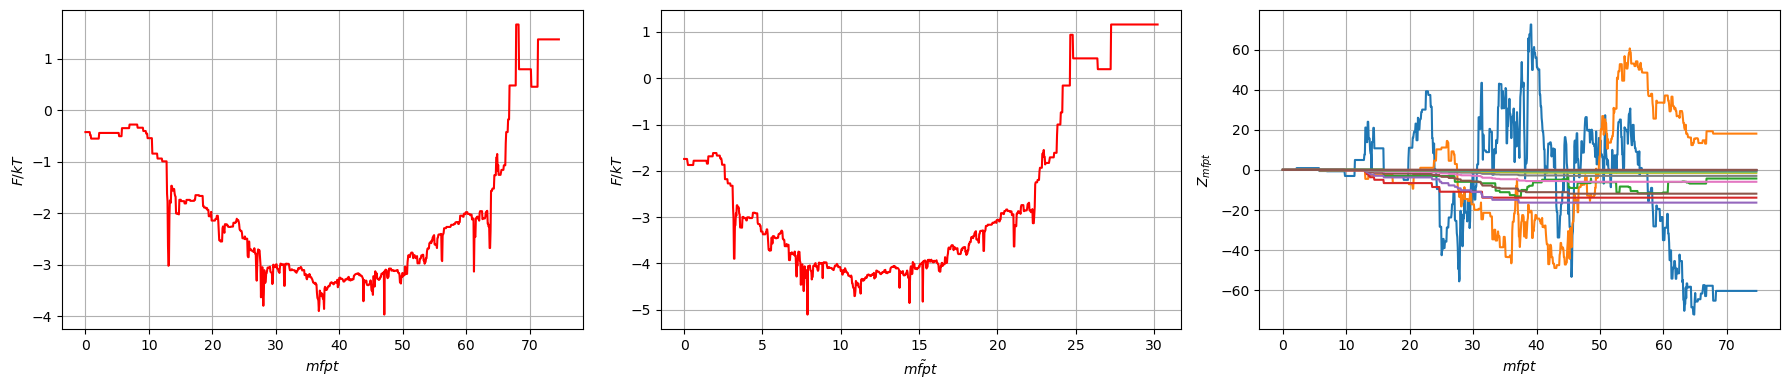

In [338]:
q.plots(lnzmfpt=False)
plt.savefig("to death selected individuals lnzmfpt=False with tuned hyperparameters.svg", format='svg', dpi=1200)

Without adjusting gamma, it would not converge. I also adjusted the envelope scale and ny (not shown), however, this did not improve the validation criterion 

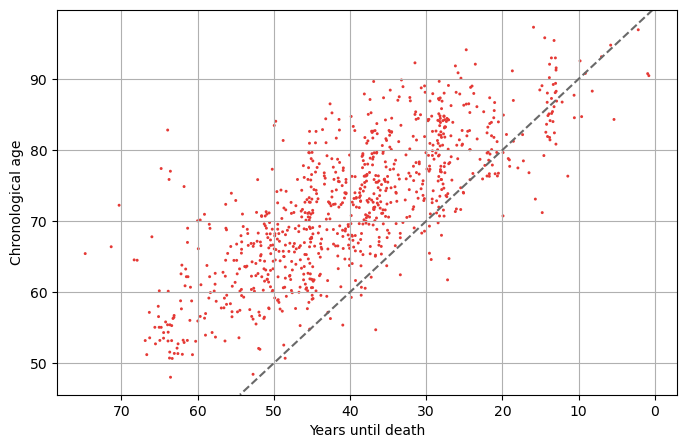

In [31]:
b = q.r
c = ttrajne

# Mask to keep only points that are NOT (0, 100)
mask = ~((b == 0) & (c == 100))

# Apply mask
b_filtered = b[mask]
c_filtered = c[mask]

plt.figure(figsize=(8, 5))
plt.scatter(b_filtered, c_filtered, edgecolor="none",
        s=18, color="#E53935", marker=".")

plt.xlabel("Years until death")
plt.ylabel("Chronological age")
plt.axline((50, 50), slope=-1, linestyle='--', color='dimgrey')
plt.gca().invert_xaxis()
plt.grid(True)
#plt.show()
plt.savefig("mfpt years to death >92 with tuned hyperparameters.svg", format='svg', dpi=1200) 

In [35]:
print("Performance")
print("Pearson r:", pearsonr(np.array(c_filtered), np.array(b_filtered))[0])

Performance
Pearson r: -0.766600209615089


Time until death still correlated with chronological age but there was less of a correlation than previously seen when setting a surrogate endpoint for everyone.

Plot time to death again against chronological age:

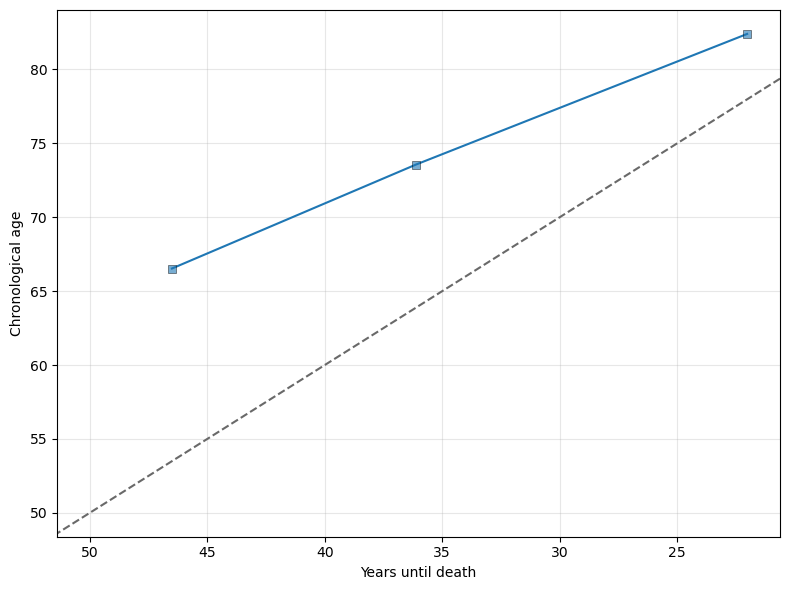

In [340]:
# 25, 54, 55, 79, 90, 102, 104, 107, 119
target_id = 4

# Filter rows for that ID
mask = ptrajne == target_id
subset_biol = b[mask][:-1]   # remove last point
subset_chron = c[mask][:-1] # remove last point

# Plot
plt.figure(figsize=(8, 6))
plt.scatter(
    subset_biol, subset_chron,
    s=28, marker='s', alpha=0.6, zorder=10,
    edgecolor="black", linewidth=0.5
)
plt.plot(subset_biol, subset_chron,)

plt.xlabel("Years until death")
plt.ylabel("Chronological age")
plt.grid(True, alpha=0.3)
plt.gca().invert_xaxis()
#plt.gca().invert_yaxis()
plt.axline((50, 50), slope=-1, linestyle= '--', color='dimgrey')
plt.tight_layout()
plt.show()

Plot time to death with the same individuals as when the surrogate endpoint was set for everyone:

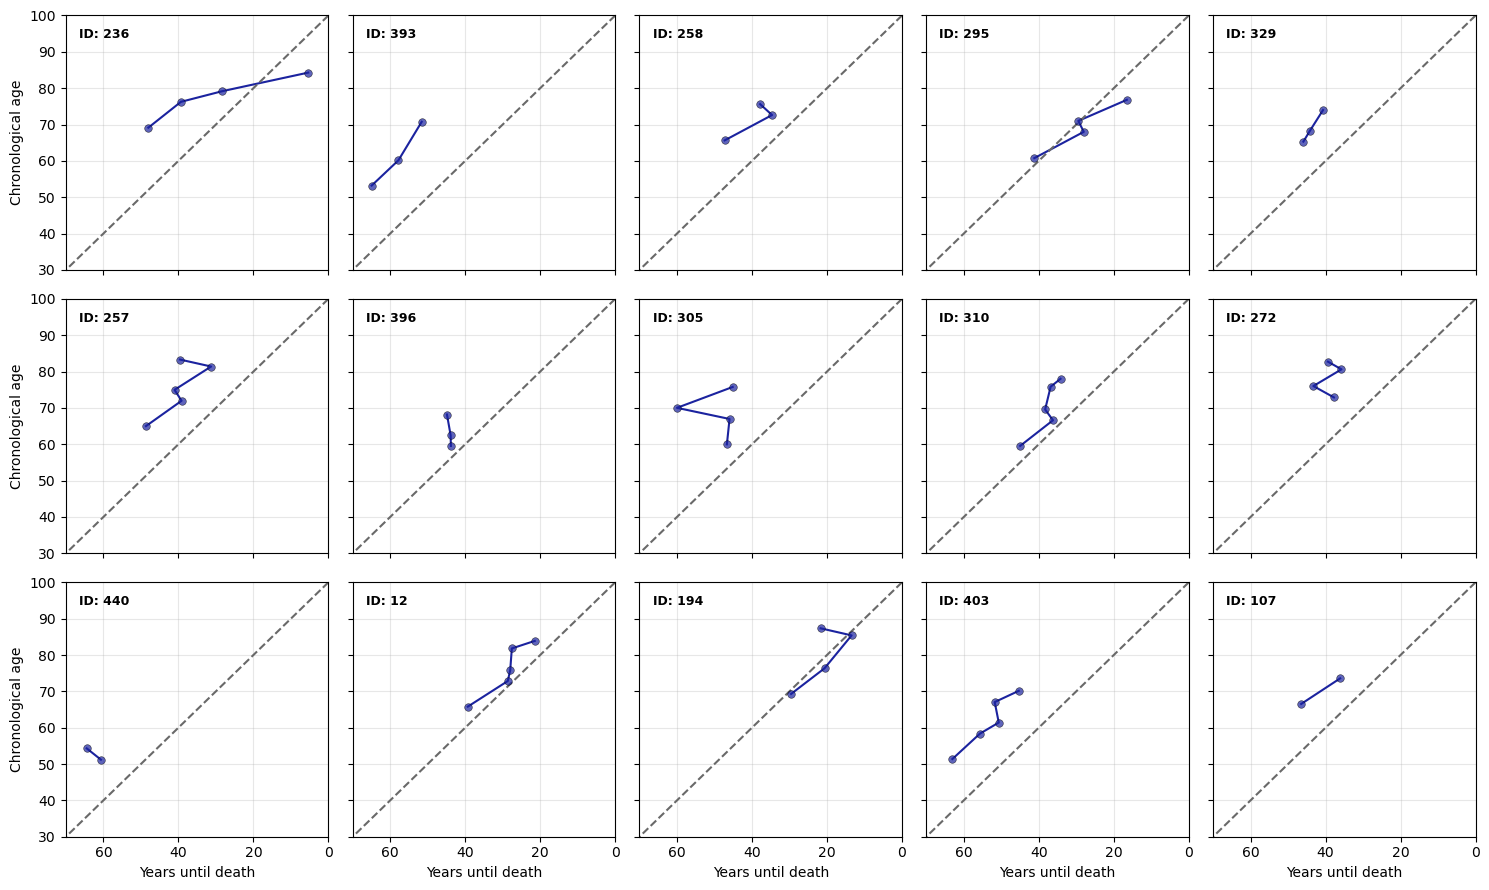

In [341]:
# Set up subplots (e.g., 4x5 grid)
fig, axes = plt.subplots(3, 5, figsize=(15, 9), sharex=True, sharey=True)
axes = axes.flatten()

nrows, ncols = 3, 5

for idx, (ax, target_id) in enumerate(zip(axes, ID_list)):
    # Filter rows for that ID
    mask = ptrajne == target_id
    subset_b = b[mask]
    subset_c = c[mask]

    # Remove final point only for ID 107
    if target_id == 107:
        subset_b = subset_biol[:-1]
        subset_c = subset_chron[:-1]

    # Scatter + line
    ax.scatter(
        subset_b, subset_c,
        s=30, color="#1b239f", marker='o', alpha=0.7, zorder=10,
        edgecolor="black", linewidth=0.4
    )
    ax.plot(subset_b, subset_c, color="#1b239f")

    # Add ID text
    ax.text(
        0.05, 0.95, f"ID: {str(target_id)}", transform=ax.transAxes,
        ha='left', va='top', fontsize=9, weight='bold'
    )
    
    ax.grid(True, alpha=0.3)
    ax.invert_xaxis()
    ax.set_xlim(70, 0)
    ax.set_ylim(30, 100)

    ax.axline((50, 50), slope=-1, linestyle='--', color='dimgrey')

    # Only label leftmost column
    if idx % ncols == 0:
        ax.set_ylabel("Chronological age", fontsize=10)

    # Only label bottom row
    if idx // ncols == nrows - 1:
        ax.set_xlabel("Years until death", fontsize=10)

plt.tight_layout()
#plt.show()
plt.savefig("mfpt time to death >92 vs chronological selected individuals.svg", format='svg', dpi=1200)